<a href="https://colab.research.google.com/github/HesterWen/Customer_Segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

## 載入資料


In [ ]:
df = pd.read_excel('online-retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 處理缺失值

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
# 因不採用其特徵，所以直接drop
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


## 特徵工程

* 處理Quantity特徵的負數問題

In [ ]:
negative = df[df['Quantity']<0].index
df = df.drop(index=negative, axis=0)
df.reset_index(drop=True)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


* 提取 **Recency** 的資料

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['gap'] = (df['InvoiceDate'].max() - df['InvoiceDate']).dt.days
df_r = df.groupby('CustomerID')['gap'].min().reset_index()
df_r

,CustomerID,gap
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4334,18280.0,277
4335,18281.0,180
4336,18282.0,7
4337,18283.0,3


* 提取 **Frequency** 的資料

In [ ]:
df_f = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
df_f

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4334,18280.0,1
4335,18281.0,1
4336,18282.0,2
4337,18283.0,16


* 提取 **Monetary** 的資料

In [ ]:
df['amount'] = df['Quantity'] * df['UnitPrice']
df_m = df.groupby('CustomerID').agg({'amount': 'sum'}).reset_index()
df_m

,CustomerID,amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


* 將 Recency、Frequency、Monetary的資料整合

In [ ]:
df_rfm = df_r.merge(df_f, on='CustomerID').merge(df_m, on='CustomerID')
df_rfm.rename(columns={'gap': 'Recency', 'InvoiceNo': 'Frequency', 'amount': 'Monetary'}, inplace=True)
df_rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4334,18280.0,277,1,180.60
4335,18281.0,180,1,80.82
4336,18282.0,7,2,178.05
4337,18283.0,3,16,2094.88


In [ ]:
df_rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.518322,4.271952,2053.793018
std,1721.889758,100.009747,7.705493,8988.248381
min,12346.000000,0.000000,1.000000,0.000000
25%,13812.500000,17.000000,1.000000,307.245000
50%,15299.000000,50.000000,2.000000,674.450000
75%,16778.500000,141.000000,5.000000,1661.640000
max,18287.000000,373.000000,210.000000,280206.020000


## 正規化

In [ ]:
df_data = df_rfm.drop('CustomerID', axis=1)  # 移除ID
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_data)  # 因數據差異較大，所以使用MinMaxScaler來標準化
df_data_scaled = scaler.transform(df_data)

## 建立 K-means 模型

In [ ]:
kmeansModel = KMeans(n_clusters=5, random_state=80, max_iter=50)
predicted = kmeansModel.fit_predict(df_data_scaled)
# 各樣本至各該群中心的距離之平方和
kmeansModel.inertia_

20.59983642158384

In [ ]:
# 各群的中心點
kmeansModel.cluster_centers_

array([[0.04405344, 0.02742455, 0.01234176],
       [0.88876973, 0.00164046, 0.00226025],
       [0.64349617, 0.00241852, 0.00214998],
       [0.40585004, 0.00564276, 0.00283508],
       [0.18403963, 0.00816025, 0.00378343]])

### 預測分群視覺化

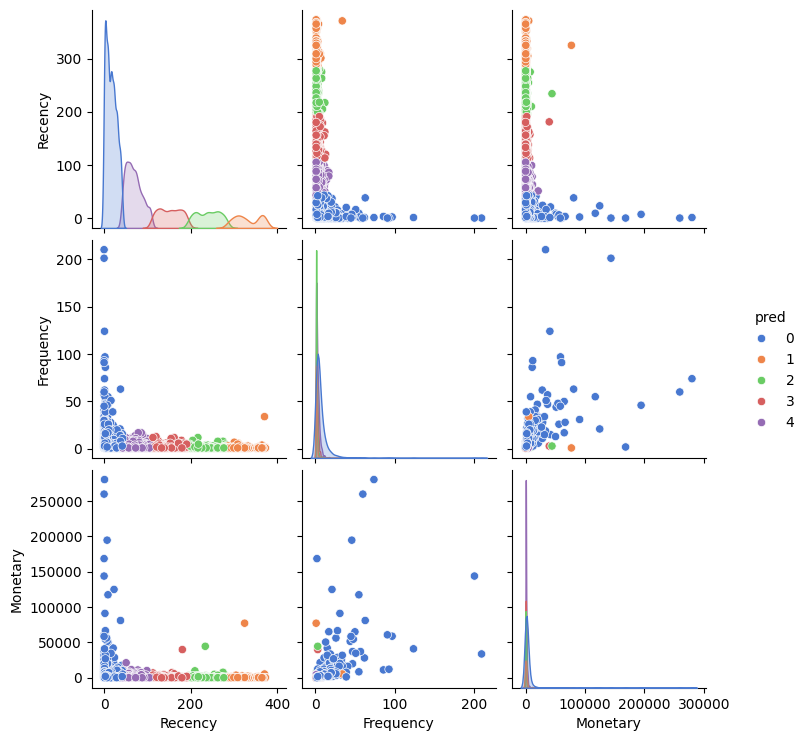

In [ ]:
df_data['pred'] = predicted
sns.pairplot(df_data, hue='pred', diag_kind='kde', palette='muted')

## Elbow Method

In [ ]:
# 將資料分1~9群來找出elbow point
kmeans_list = [KMeans(n_clusters=k, random_state=71).fit(df_data_scaled)
          for k in range(1, 10)]
# 分越多群，inertia會越小
inertias = [model.inertia_ for model in kmeans_list]

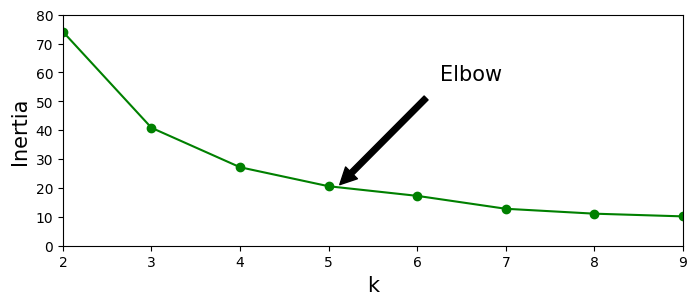

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 10), inertias, 'go-')
plt.xlabel('k', fontsize=15)
plt.ylabel('Inertia', fontsize=15)
# 標記肘部位置
plt.annotate('Elbow',
       xy=(5, inertias[5]),
       xytext=(0.55, 0.75),
       textcoords='figure fraction',
       fontsize=15,
       arrowprops=dict(facecolor='black', shrink=0.1))  # 讓箭頭稍微縮短一點
plt.axis([2, 9, 0, 80])
plt.show()

## Silhouette Analysis


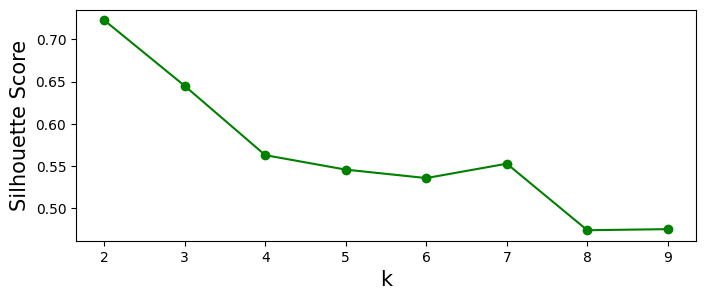

In [ ]:
# 越接近1越好
silhouette_scores = [silhouette_score(df_data_scaled, model.labels_)
            for model in kmeans_list[1:]]  # 跳過k=1
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, 'go-')
plt.xlabel('k', fontsize=15)
plt.ylabel('Silhouette Score', fontsize=15)
plt.show()

## 結論:綜合 Elbow Method 和 Silhouette Analysis的分析結果，選擇分4群或5群的效果都不錯